In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from einops import rearrange, repeat, reduce, unpack, pack
from einops.layers.torch import Rearrange

import matplotlib.pyplot as plt

순서를 반영하는 기법

## 1D Positional Encoding

In [ ]:
d_model = 512
length = 10 # 시퀀스 길이
pe = torch.zeros(length, d_model)
# (torch.Size([10, 1])
position = torch.arange(0, length).unsqueeze(1) # [0, 1, 2, ..., 9]

# div_term
# 주파수를 조절하는 스케일링 값, torch.Size([256]
div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))

pe[:, 0::2] = torch.sin(position.float() * div_term)
pe[:, 1::2] = torch.cos(position.float() * div_term)


In [8]:
position.shape, div_term.shape, (position.float() * div_term).shape

(torch.Size([10, 1]), torch.Size([256]), torch.Size([10, 256]))

In [5]:
pe, pe.shape

(tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 6.5699e-01,  7.5390e-01,  4.5239e-01,  ...,  1.0000e+00,
           7.2564e-04,  1.0000e+00],
         [ 9.8936e-01, -1.4550e-01,  9.9067e-01,  ...,  1.0000e+00,
           8.2931e-04,  1.0000e+00],
         [ 4.1212e-01, -9.1113e-01,  6.7637e-01,  ...,  1.0000e+00,
           9.3297e-04,  1.0000e+00]]),
 torch.Size([10, 512]))

## 2D Sinusoidal Positional Embedding

- D = 전체 임베딩 차원, 절반을 width, 나머지 절반은 hegiht
- 절반에서도 짝수 채널 (2i)은 sin, 홀수채널(2i+1)은 cos
\begin{aligned}
PE(h, w, 2i) &= \sin\!\Bigl(\frac{\,h\,}{10000^{\frac{2i}{D/2}}}\Bigr), \\
PE(h, w, 2i + 1) &= \cos\!\Bigl(\frac{\,h\,}{10000^{\frac{2i}{D/2}}}\Bigr), \\[6pt]
PE(h, w, 2j + \tfrac{D}{2}) &= \sin\!\Bigl(\frac{\,w\,}{10000^{\frac{2j}{D/2}}}\Bigr), \\
PE(h, w, 2j + 1 + \tfrac{D}{2}) &= \cos\!\Bigl(\frac{\,w\,}{10000^{\frac{2j}{D/2}}}\Bigr),
\end{aligned}

$
where \quad 0 \le h < H,\; 0 \le w < W,\; i,j \in \bigl\{0,1,2,\dots,\frac{D}{4}-1\bigr\}.
$

- 구현 차이
    - 채널 순서(세로/가로 분배)를 어떻게 할 것이냐 : cocat 순서는 shape만 맞으면 어떻게든 할 수 있다.
        - 방법 1 : (세로 sin, 세로 cos, 가로 sin, 가로 cos)
        - 방법 2: 채널 절반은 전부 세로(h), 나머지 절반은 전부 가로(w)
    -  α를 어떻게 분포시키느냐
\begin{aligned}
PE(h,w) \;=\; 
\Bigl[\,
\underbrace{\sin(\alpha \cdot h),\, \cos(\alpha \cdot h),\, \dots}_{\text{세로축}},\;
\underbrace{\sin(\beta \cdot w),\, \cos(\beta \cdot w),\, \dots}_{\text{가로축}}
\Bigr]
\end{aligned}

$
\alpha,\, \beta \text{는 } 10000^{-\frac{2i}{d}}
$

In [ ]:
d_model = 128
height= 16
width = 16

pe = torch.zeros(d_model, height, width)
d_model = int(d_model/2)
div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0)/d_model)) # [d_model/2]

pos_w = torch.arange(0, width).unsqueeze(1) # [width, 1]
pos_h = torch.arange(0, height).unsqueeze(1) # [height, 1]


print(torch.sin(pos_w * div_term).shape) # pos x d_model/4
print(torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height ,1).shape) # torch.Size([32, 16, 16])

pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
pe[d_model+1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

# pe.shape : [128, 16, 16]

torch.Size([16, 32])
torch.Size([32, 16, 16])


In [25]:
x_sin_0 = pe[0]
x_cos_1 = pe[1]
y_sin_64 = pe[d_model//2]
y_cos_65 = pe[d_model//2 + 1]

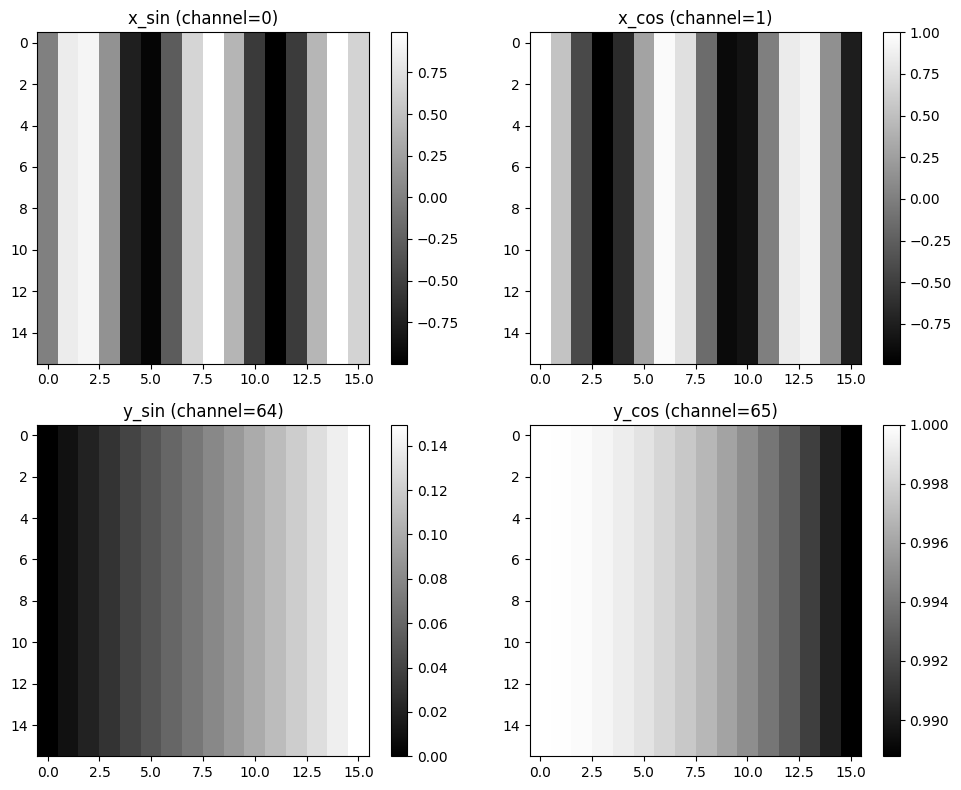

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im0 = axs[0,0].imshow(x_sin_0.cpu(), cmap='gray')
axs[0,0].set_title('x_sin (channel=0)')
fig.colorbar(im0, ax=axs[0,0])

im1 = axs[0,1].imshow(x_cos_1.cpu(), cmap='gray')
axs[0,1].set_title('x_cos (channel=1)')
fig.colorbar(im1, ax=axs[0,1])

im2 = axs[1,0].imshow(y_sin_64.cpu(), cmap='gray')
axs[1,0].set_title('y_sin (channel=64)')
fig.colorbar(im2, ax=axs[1,0])

im3 = axs[1,1].imshow(y_cos_65.cpu(), cmap='gray')
axs[1,1].set_title('y_cos (channel=65)')
fig.colorbar(im3, ax=axs[1,1])

plt.tight_layout()
plt.show()

In [33]:
def posemb_sincos_2d(patches, temperature=10_000, dtype=torch.float32):
    """
    paches : [b, h, w, dim]

    returns : [h, w, dim]
    """
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    y, x = torch.meshgrid(torch.arange(h), torch.arange(w))
    # (tensor([[ 0,  0,  0,  ...,  0,  0,  0],
    #      [ 1,  1,  1,  ...,  1,  1,  1],
    #      [ 2,  2,  2,  ...,  2,  2,  2],
    #      ...,
    #      [29, 29, 29,  ..., 29, 29, 29],
    #      [30, 30, 30,  ..., 30, 30, 30],
    #      [31, 31, 31,  ..., 31, 31, 31]]),
    # tensor([[ 0,  1,  2,  ..., 29, 30, 31],
    #         [ 0,  1,  2,  ..., 29, 30, 31],
    #         [ 0,  1,  2,  ..., 29, 30, 31],
    #         ...,
    #         [ 0,  1,  2,  ..., 29, 30, 31],
    #         [ 0,  1,  2,  ..., 29, 30, 31],
    #         [ 0,  1,  2,  ..., 29, 30, 31]]))
    assert (dim % 4) == 0, 'feature dimension must be multiple of 4 for sincos emb'

    # 주파수 계산
    # 예: 만약 dim=64라면 dim//4=16, 아래는 0..15를 (dim//4 - 1)로 나누고 temperature^(...) 로 주파수를 만든다
    # (tensor([1.0000e+00, 4.6416e-02, 2.1544e-03, 1.0000e-04]), torch.Size([4]))
    omega = torch.arange(dim // 4, device = device) / (dim // 4 - 1)
    omega = 1. / (temperature ** omega)

    # y, x를 1D로 펴서 [h*w, 1] shape로 만든 뒤 각 위치에 대해 omega를 곱해 [h*w, dim//4] 로 확장
    y = y.flatten()[:, None] * omega[None, :]
    # (torch.Size([1024, 1]),
    # tensor([[ 0],
    #         [ 0],
    #         [ 0],
    #         ...,
    #         [31],
    #         [31],
    #         [31]]))

    x = x.flatten()[:, None] * omega[None, :] 
    # (torch.Size([1024, 1]),
    # tensor([[ 0],
    #         [ 1],
    #         [ 2],
    #         ...,
    #         [29],
    #         [30],
    #         [31]]))

    
    # x, y 각각 sin/cos를 구해 4개 채널( x.sin(), x.cos(), y.sin(), y.cos() )을 마지막 차원으로 concat
    #    shape: [h*w, dim//4 * 4] = [h*w, dim]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim = 1)
    pe = pe.type(dtype)

    # pe를 다시 2D로 reshape: 최종 shape = [h, w, dim]
    # (h*w, d) -> (h, w, d)
    return rearrange(pe, '(h w) d -> h w d', h = h, w = w)

In [ ]:
patches = torch.zeros(1, 16, 16, 64)
pe_2d = posemb_sincos_2d(patches)

In [36]:
x_sin = pe_2d[..., :64//4]
x_cos = pe_2d[..., 64//4: 64//2]
y_sin = pe_2d[..., 64//2: 3*64//4]
y_cos = pe_2d[..., 3*64//4:]


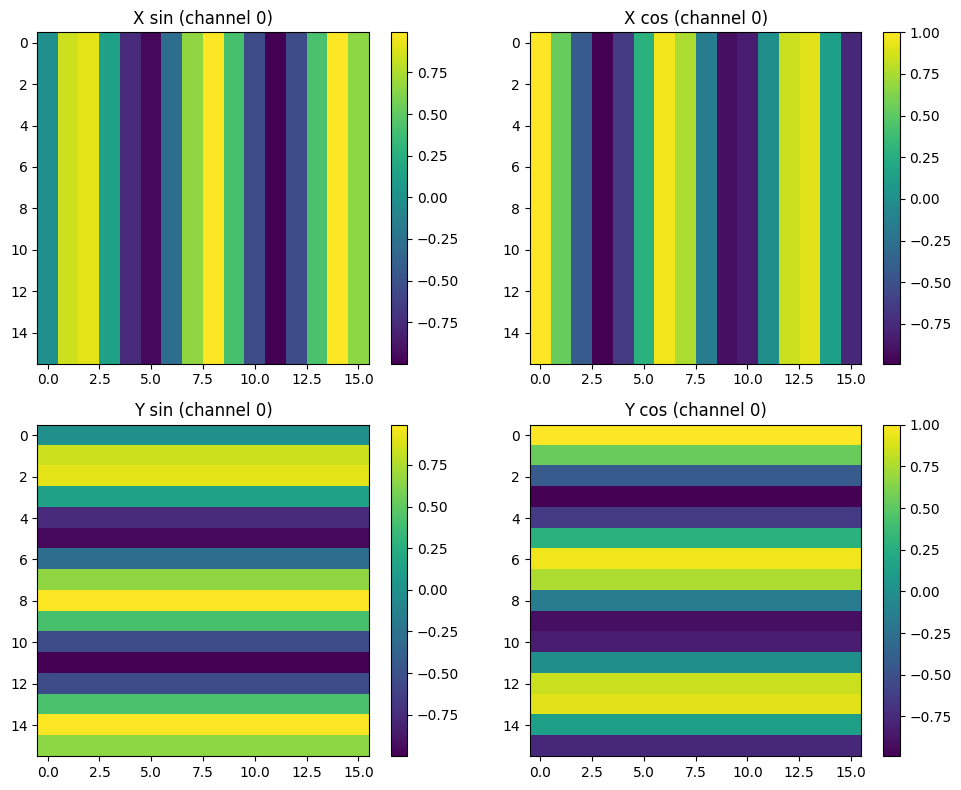

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im0 = axs[0,0].imshow(x_sin[..., 0].cpu(), cmap='viridis')
axs[0,0].set_title('X sin (channel 0)')
fig.colorbar(im0, ax=axs[0,0])

im1 = axs[0,1].imshow(x_cos[..., 0].cpu(), cmap='viridis')
axs[0,1].set_title('X cos (channel 0)')
fig.colorbar(im1, ax=axs[0,1])

im2 = axs[1,0].imshow(y_sin[..., 0].cpu(), cmap='viridis')
axs[1,0].set_title('Y sin (channel 0)')
fig.colorbar(im2, ax=axs[1,0])

im3 = axs[1,1].imshow(y_cos[..., 0].cpu(), cmap='viridis')
axs[1,1].set_title('Y cos (channel 0)')
fig.colorbar(im3, ax=axs[1,1])


plt.tight_layout()
plt.show()